# Intro

See [here](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)

Human activity recognition using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="IMAGE ALT TEXT HERE" width="400" height="300" border="10" /></a>

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing.

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

# Imports

In [1]:
##########
# basics #
##########

import warnings
warnings.filterwarnings('ignore')
import collections
import datetime
import glob
import hashlib
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time

###########
# science #
###########

import scipy as sp
import numpy as np
import pandas as pd
rseed = random.seed(42)
np.random.seed(rseed)

######
# ml #
######

import theano as thno
import keras as krs
import tensorflow as tf

###################
# sklearn tooling #
###################

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=False, theme='pearl')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted', n_colors=15, desat=None)
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

############
# sys info #
############

%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,sklearn,theano,keras,tensorflow,\
matplotlib,seaborn,plotly

Using TensorFlow backend.
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Ken Cavagnolo 
last updated: Tue Oct 25 2016 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
scipy 0.18.1
pandas 0.19.0
sklearn 0.18
theano 0.8.2
keras 1.1.0
tensorflow 0.10.0rc0
matplotlib 1.5.3
seaborn 0.7.1
plotly 1.12.9

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : ubuntu
Git hash   : 1ac763e435ea438d89f382aa559adeb760c6b98e


# Download Data

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) is described on the UCI Machine Learning Repository:

In [2]:
rootpath = '/home/kcavagnolo/ml_fun/deep/lstm_activity/'
datadir = 'data/'
datapath = datadir + 'UCI HAR Dataset/'

In [3]:
os.chdir(rootpath)
!pwd && ls
os.chdir(datadir)
!pwd && ls

/home/kcavagnolo/ml_fun/deep/lstm_activity
data  lstm_har.ipynb  README.md  UCI HAR Dataset.zip
/home/kcavagnolo/ml_fun/deep/lstm_activity/data
UCI HAR Dataset


In [4]:
# import copy
import os
from subprocess import call
print("Downloading...")
if not os.path.exists("UCI HAR Dataset.zip"):
    call(
        'wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"',
        shell=True
    )
    print("Downloading done.\n")
else:
    print("Dataset already downloaded. Did not download twice.\n")

Downloading...



In [6]:
print("Extracting...")
extract_directory = os.path.abspath(datapath)
if not os.path.exists(extract_directory):
    call('unzip -nq "UCI HAR Dataset.zip"', shell=True)
    print("Extracting successfully done to {}.".format(extract_directory))
else:
    print("Dataset already extracted. Did not extract twice.\n")
!pwd && ls
os.chdir(rootpath)
!pwd && ls

Extracting...
Extracting successfully done to /home/kcavagnolo/ml_fun/deep/lstm_activity/data/data/UCI HAR Dataset.
/home/kcavagnolo/ml_fun/deep/lstm_activity/data
__MACOSX  UCI HAR Dataset  UCI HAR Dataset.zip
/home/kcavagnolo/ml_fun/deep/lstm_activity
data  lstm_har.ipynb  README.md  UCI HAR Dataset.zip


# Prep data

In [33]:
# load data
def load_X(paths):
    X_signals = []
    for p in paths:
        f = open(p, 'rb')
        evt = [np.array(s, dtype=np.float32) for s in [r.replace('  ', ' ').strip().split(' ') for r in f]]
        X_signals.append(evt)
        f.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

In [34]:
# Load "y"
def load_y(path):
    f = open(path, 'rb')
    y_ = np.array([e for e in [r.replace('  ', ' ').strip().split(' ') for r in f]], dtype=np.int32)
    f.close()
    return y_ - 1 # subtract 1 for 0-based encoding

In [35]:
# get all paths to data files
import glob
X_train_dir = rootpath + datapath + "train/Inertial Signals/"
X_train_signals_paths = sorted([f for f in glob.glob(X_train_dir+'*.txt')])
X_test_dir = rootpath + datapath + "test/Inertial Signals/"
X_test_signals_paths = sorted([f for f in glob.glob(X_test_dir+'*.txt')])

# load X
X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

# load y
y_train = load_y(rootpath + datapath + "train/y_train.txt")
y_test = load_y(rootpath + datapath + "test/y_test.txt")

# y encodings (found in activity_labels.txt)
labels = ["walk",
          "walk_up",
          "walk_down",
          "sit",
          "stand",
          "lay"]

In [38]:
# data description 
train_len = len(X_train)
test_len = len(X_test)
n_steps = len(X_train[0])
n_input = len(X_train[0][0])

# Some debugging info
print "X train shape:", X_train.shape
print "Mean, std:", np.mean(X_train), np.std(X_train)
print "y train shape:", y_train.shape
print ""
print "X test shape:", X_test.shape
print "Mean, std:", np.mean(X_test), np.std(X_test)
print "y test shape:", y_test.shape

X train shape: (7352, 128, 9)
Mean, std: 0.102066 0.402165
y train shape: (7352, 1)

X test shape: (2947, 128, 9)
Mean, std: 0.0991399 0.395671
y test shape: (2947, 1)


# Utility functions

In [47]:
def LSTM_RNN(_X, _istate, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset: 
    # https://tensorhub.com/aymericdamien/tensorflow-rnn

    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size

    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) # (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.matmul(_X, _weights['hidden']) + _biases['hidden']

    # Define a lstm cell with tensorflow
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)#, state_is_tuple=True)

    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(0, n_steps, _X) # n_steps * (batch_size, n_hidden)

    # Get lstm cell output
    outputs, states = tf.nn.rnn(lstm_cell, _X, initial_state=_istate)

    # Linear activation
    # Get inner loop last output
    return tf.matmul(outputs[-1], _weights['out']) + _biases['out']

In [48]:
def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

In [49]:
def one_hot(y_):  
    ohe = preprocessing.OneHotEncoder()
    return ohe.fit_transform(y_).toarray()

# Build

In [89]:
tf.reset_default_graph()

In [90]:
# lstm params
n_hidden = 30
n_classes = len(labels)
learning_rate = 0.01
training_iters = train_len * 100
batch_size = 1500
display_iter = 15000

In [94]:
print X_train.shape[0]
print X_train.shape[1]
print X_train.shape[2]

7352
128
9


In [101]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# build model and train
model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=()
#model.add(Dropout(0.2))
#model.add(Dense(y_train.shape[1], activation='relu'))
model.compile(loss="mse", optimizer="adam")

In [102]:
#bsize = random.randint(window, 3*window)
model.fit(X_train, y_train, verbose=1)

Exception: Error when checking model target: expected lstm_17 to have shape (None, 30) but got array with shape (7352, 1)

In [51]:
# Graph input/output
x = tf.placeholder("float", [None, n_steps, n_input])
istate = tf.placeholder("float", [None, 2*n_hidden]) #state & cell => 2x n_hidden
y = tf.placeholder("float", [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, istate, weights, biases)

# Loss, optimizer and evaluation
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y)) # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Train

In [52]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.initialize_all_variables()
sess.run(init)

# Perform Training steps with "batch_size" iterations at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys,
            istate: np.zeros((batch_size, 2*n_hidden))
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print "Iter " + str(step*batch_size) + \
              ", Batch Loss= " + "{:.6f}".format(loss) + \
              ", Accuracy= " + "{}".format(acc)
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test),
                istate: np.zeros((len(X_test), 2*n_hidden))
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print "FIXED DISPLAY STEP: " + \
              "Batch Loss= {}".format(loss) + \
              ", Accuracy= " + "{}".format(acc)
    step += 1
print "Optimization Finished!"

# Accuracy for test data
one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test),
        istate: np.zeros((len(X_test), 2*n_hidden))
    }
)
test_losses.append(final_loss)
test_accuracies.append(accuracy)
print "FINAL RESULT: " + \
      "Batch Loss= {}".format(final_loss) + \
      ", Accuracy= " + "{}".format(accuracy)

Iter 1500, Batch Loss= 4.449417, Accuracy= 0.120666667819
test_dir SET DISPLAY STEP: Batch Loss= 2.46767115593, Accuracy= 0.184933826327
Iter 15000, Batch Loss= 1.240909, Accuracy= 0.439333319664
test_dir SET DISPLAY STEP: Batch Loss= 1.26127171516, Accuracy= 0.439769268036
Iter 30000, Batch Loss= 0.986687, Accuracy= 0.574666678905
test_dir SET DISPLAY STEP: Batch Loss= 1.03885686398, Accuracy= 0.562606036663
Iter 45000, Batch Loss= 0.860126, Accuracy= 0.617999970913
test_dir SET DISPLAY STEP: Batch Loss= 0.920174241066, Accuracy= 0.616219878197
Iter 60000, Batch Loss= 0.717557, Accuracy= 0.66333335638
test_dir SET DISPLAY STEP: Batch Loss= 0.772662520409, Accuracy= 0.650152683258
Iter 75000, Batch Loss= 0.648106, Accuracy= 0.709333360195
test_dir SET DISPLAY STEP: Batch Loss= 0.676847338676, Accuracy= 0.690193414688
Iter 90000, Batch Loss= 0.577636, Accuracy= 0.750666677952
test_dir SET DISPLAY STEP: Batch Loss= 0.658200621605, Accuracy= 0.709195792675
Iter 105000, Batch Loss= 0.45972

# Evaluate

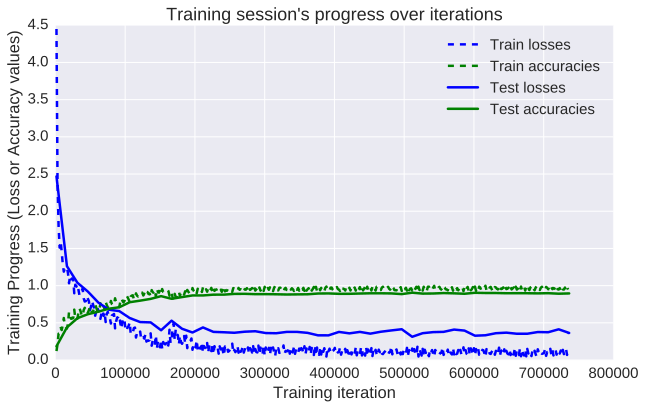

In [53]:
width = 12
height = 12
plt.figure(figsize=(10,6))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1] + [training_iters])
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 89.5486950874%

Precision: 89.5179734418%
Recall: 89.5486935867%
f1_score: 89.5194924894%

Confusion Matrix:
[[453  15  28   0   0   0]
 [ 15 435  18   0   3   0]
 [ 17  10 387   1   5   0]
 [  1  25   0 391  74   0]
 [  0   5   0  91 436   0]
 [  0   0   0   0   0 537]]

Confusion matrix (normalised to % of total test data):
[[ 15.37156391   0.5089922    0.95011878   0.           0.           0.        ]
 [  0.5089922   14.76077461   0.61079061   0.           0.10179844   0.        ]
 [  0.57685781   0.33932811  13.13199806   0.03393281   0.16966406   0.        ]
 [  0.03393281   0.84832031   0.          13.26772976   2.51102829   0.        ]
 [  0.           0.16966406   0.           3.0878861   14.79470539   0.        ]
 [  0.           0.           0.           0.           0.          18.22192001]]
Note: training and testing data is not equally distributed amongst classes, so it is normal that more than a 6th of the data is correctly classifier in the last catego

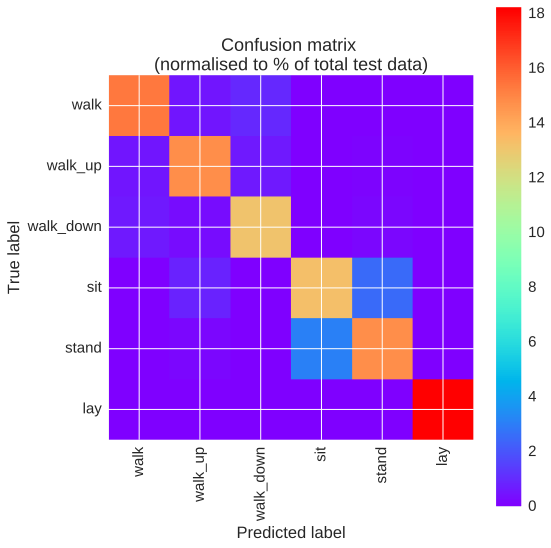

In [54]:
# Results
predictions = one_hot_predictions.argmax(1)
print "Testing Accuracy: {}%".format(100*accuracy)

print ""
print "Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted"))
print "Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted"))
print "f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted"))

print ""
print "Confusion Matrix:"
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print confusion_matrix
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print ""
print "Confusion matrix (normalised to % of total test data):"
print normalised_confusion_matrix
print ("Note: training and testing data is not equally distributed amongst classes, "
       "so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
plt.figure(figsize=(8,8))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
sess.close()

## Conclusion

Outstandingly, the accuracy is of 89.888%! 

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so those predictions are extremely accurate.

I specially did not expect such good results for guessing between "WALKING" "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS" as a cellphone. Tought, it is still possible to see a little cluster on the matrix between those 3 classes. This is great.

It is also possible to see that it was hard to do the difference between "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level.